## GSEA results (figure 4b, c, extended data figure 8)

### Load modules, set paths, load files:

In [1]:
import pandas as pd
import scanpy as sc
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

optional, for pretty code formatting:

In [2]:
%load_ext lab_black

set paths:

In [3]:
dir_GSEA_results = "../../results/covariate_modeling/GSEA/"
dir_figures = "./figures/"
path_celltype_df = "../../supporting_files/celltype_structure_and_colors/manual_anns_grouped_order_and_colors.csv"
path_HLCA = "../../data/HLCA_core_h5ads/HLCA_v1.h5ad"

load files:

In [4]:
cts_ordered_df = pd.read_csv(path_celltype_df, index_col=0)
adata = sc.read_h5ad(path_HLCA)

get celltype names in bio order:

In [5]:
cts = cts_ordered_df.index.tolist()

create empty dictionary in which to store figures:

In [6]:
FIGURES = dict()

### Import GSEA results and generate related plots:

In [7]:
covariates = [
    "BMI",
    "age",
    "anatomical_region_ccf_score",
    "sexfemale",
    "smoking_status_num",
]
alpha = 0.05

In [8]:
gobp_results = dict()

Import results. For BMI, also store the number of sign. upregulated/downregulated sets.

In [9]:
gene_set_numbers_BMI = pd.DataFrame(
    index=cts,
    columns=["gobp_total", "gobp_n_up", "gobp_n_down", "gobp_perc_up"],
)

for ct in cts:
    ct_no_space = ct.replace(" ", "_")
    for cov in covariates:
        gobp_file_path = os.path.join(
            dir_GSEA_results, f"{ct_no_space}-{cov}-GO_BP-Total.tsv"
        )
        if os.path.exists(gobp_file_path):
            res = pd.read_csv(gobp_file_path, sep="\t", index_col=0)
            res = res.loc[res.FDR < alpha, :].copy()
            if cov == "BMI":
                n_genesets = res.shape[0]
                n_genesets_up = (res.Direction == "Up").sum()
                n_genesets_down = (res.Direction == "Down").sum()
                perc_genesets_up = round(n_genesets_up / n_genesets * 100, 0)
                #                 print(f"{ct} {cov} {n_genesets} ({perc_genesets_up}% up)")
                gene_set_numbers_BMI.loc[
                    ct, ["gobp_total", "gobp_n_up", "gobp_n_down", "gobp_perc_up"]
                ] = [
                    n_genesets,
                    n_genesets_up,
                    n_genesets_down,
                    perc_genesets_up,
                ]

            gobp_results[f"{ct}_{cov}"] = res

Sort number of cell types by total number of significant BMI-associated gene sets. The text in the paper, and the figures below will focus on these cell types for BMI:

In [10]:
gene_set_numbers_BMI.sort_values(by="gobp_total", inplace=True, ascending=False)

Show resulting table. You can see that certain top cell types have largely down-regulated gene sets:

In [11]:
gene_set_numbers_BMI

,gobp_total,gobp_n_up,gobp_n_down,gobp_perc_up
Alveolar macrophages,183,1,182,1
Plasma cells,177,103,74,58
Secretory,172,14,158,8
AT2,163,4,159,2
Plasmacytoid DCs,146,66,80,45
Basal,113,109,4,96
T cell lineage,66,37,29,56
Pericytes,61,36,25,59
Monocytes,31,27,4,87
Monocyte-derived Mφ,25,4,21,16


We will show that balance of up-vs-downregulated gene sets in the following bar plot (extended data figure 8b). We only show the results for cell types that have at least 10 significantly BMI-associated gene sets.

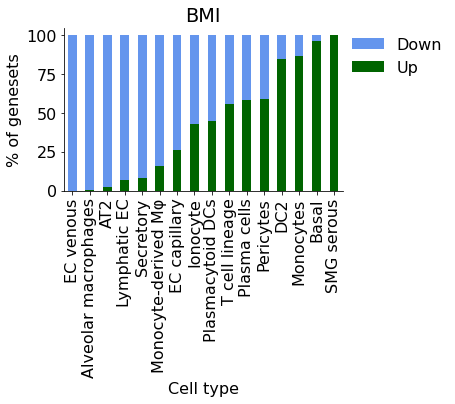

In [12]:
# normalize gene set proportions
gene_set_numbers_BMI_norm = (
    gene_set_numbers_BMI.loc[:, ["gobp_n_up", "gobp_n_down"]].divide(
        gene_set_numbers_BMI.gobp_total, axis=0
    )
    * 100
)
# keep only cell types with at least 10 gene sets
gene_set_numbers_BMI_norm = gene_set_numbers_BMI_norm.loc[
    gene_set_numbers_BMI.gobp_total >= 10, :
].copy()
# sort
gene_set_numbers_BMI_norm.sort_values(by="gobp_n_up", inplace=True)
# plot
fz = 16
with plt.rc_context(
    {
        "figure.figsize": (5, 3),
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()

    gene_set_numbers_BMI_norm.loc[:, ["gobp_n_up", "gobp_n_down"]].plot(
        kind="bar",
        stacked=True,
        color=["darkgreen", "cornflowerblue"],
        ax=ax,  # custom_palette_1
    )
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], ["Down", "Up"], frameon=False, loc=(1.01, 0.67))
    plt.ylabel("% of genesets")
    plt.xlabel("Cell type")
    plt.title("BMI")
    plt.xticks(rotation=90)
    plt.show()
    FIGURES["ED8b_BMI_genesets_up_down_per_ct"] = fig
    plt.close()

Now show a selection of significant gene sets for secretory cells, alveolar macrophages, plasma cells and AT2 cells (top 4 BMI cell types in terms of number of significantly associated gene sets):

Specify selected gene sets per cell type, for BMI:

In [13]:
selected_terms_BMI = dict()

In [14]:
selected_terms_BMI["Secretory"] = [
    "GO_LUNG_CELL_DIFFERENTIATION",
    "GO_CELLULAR_RESPONSE_TO_INSULIN_STIMULUS",
    "GO_GLYCOPROTEIN_BIOSYNTHETIC_PROCESS",
    "GO_PHOSPHOLIPID_BIOSYNTHETIC_PROCESS",
]
selected_terms_BMI["AT2"] = [
    "GO_OXIDATIVE_PHOSPHORYLATION",
    "GO_PEPTIDE_BIOSYNTHETIC_PROCESS",
    "GO_MITOTIC_DNA_REPLICATION",
    "GO_ATP_METABOLIC_PROCESS",
    "GO_GENERATION_OF_PRECURSOR_METABOLITES_AND_ENERGY",
]
selected_terms_BMI["Alveolar macrophages"] = [
    "GO_OXIDATIVE_PHOSPHORYLATION",
    "GO_PEPTIDE_BIOSYNTHETIC_PROCESS",
    "GO_RESPONSE_TO_TYPE_I_INTERFERON",
    "GO_CELLULAR_AMINO_ACID_METABOLIC_PROCESS",
]
selected_terms_BMI["Plasma cells"] = [
    "GO_CELL_CYCLE_DNA_REPLICATION",
    "GO_DNA_REPAIR",
    "GO_INFLAMMATORY_RESPONSE",
    "GO_OXIDATIVE_PHOSPHORYLATION",
]

reduced version, with selected gene sets:

In [15]:
def plot_GSEA_results(celltype_name, covariate_name, gobp_results, fz=15):
    """Function to plot barplot of GSEA results.
    Arguments:
    celltype_name
        str, name of cell type (for figure labels)
    covariate_name
        str, name of covariate (for figure labels)
    gobp_results
        pandas dataframe, containing the GSEA results for the cell type,
        including only the gene sets of interest
    Returns:
    matplotlib figure
    """
    with plt.rc_context(
        {
            "xtick.labelsize": fz,
            "ytick.labelsize": fz,
            "axes.spines.right": False,
            "axes.spines.top": False,
            "xtick.bottom": True,
            "ytick.left": True,
        }
    ):
        # direct significance depending on up or downregulation of gene set
        # or use only for coloring
        FDR_color = [
            np.log10(FDR) if direc == "Down" else -np.log10(FDR)
            for FDR, direc in zip(
                gobp_results.FDR,
                gobp_results.Direction,
            )
        ]
        # order: now independent of direction (can also make it dependent, using above code)
        FDR_order = -np.log10(gobp_results.FDR)
        FDR_values = -np.log10(gobp_results.FDR)
        # gene set names
        genesets = gobp_results.index
        # sort both based on x:
        genesets = [gs for _, gs in sorted(zip(FDR_order, genesets))]
        # clean up gene sets:
        genesets_clean = list()
        for gs in genesets:
            if (
                gs
                == "GO_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_PEPTIDE_ANTIGEN_VIA_MHC_CLASS_I"
            ):
                gs = "GO_MHC_I_ANTIGEN_PROCESSING_AND_PRESENTATION*"
            gs = gs[3:]  # remove "GO_"
            gs = gs.replace("_", " ")
            gs = gs.lower().capitalize()
            gs = (
                gs.replace("atp", "ATP")
                .replace("Atp", "ATP")
                .replace("dna", "DNA")
                .replace("Dna", "DNA")
                .replace("type i", "type I")
                .replace("Mhc i", "MHC-I")
            )
            genesets_clean.append(gs)
        FDR_values = [FDR_v for _, FDR_v in sorted(zip(FDR_order, FDR_values))]
        FDR_color = [FDR_c for _, FDR_c in sorted(zip(FDR_order, FDR_color))]
        fig, ax = plt.subplots(figsize=(5, 0.3 * len(genesets)))
        ax.barh(
            y=genesets_clean,
            width=FDR_values,
            #         height=0.4,
            color=[
                "darkgreen" if direc > 0 else "cornflowerblue" for direc in FDR_color
            ],
        )
        plt.xlabel("-log10(p-value)", fontsize=fz)
        plt.ylabel("GO:BP term", fontsize=fz)
        covariate_name_for_title = covariate_name.replace("_", " ")
        plt.title(
            f"{celltype_name}, {covariate_name_for_title}",
            fontsize=fz,
        )
        tick_interval = 1
        if max(FDR_values) > 5:
            tick_interval = 2
        plt.xticks(np.arange(0, max(FDR_values), tick_interval))

        # plt.xlim((0, 9))
        plt.grid(False)
        plt.show()
        return fig

In [16]:
cov = "BMI"

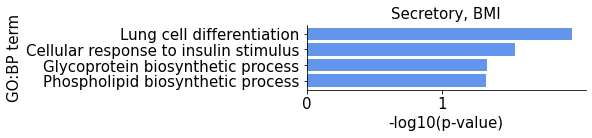

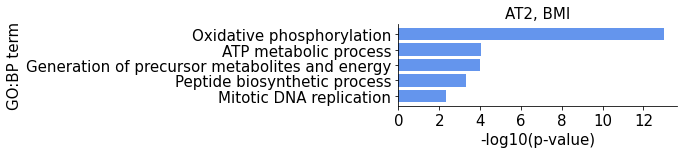

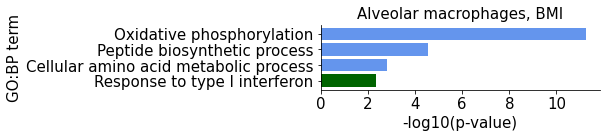

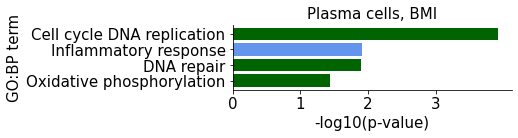

In [17]:
for ct, ct_terms in selected_terms_BMI.items():
    res = gobp_results[f"{ct}_{cov}"].loc[ct_terms, :]
    FIGURES[f"4c_{cov}_{ct}_genesets"] = plot_GSEA_results(ct, cov, res)

Show the same type of figures for anatomical region ccf score, for the 3 major airway epithelial cell types (Secretory, multiciliated, and basal cells) (figure 4b):

To show:  
- MHC-I presentation down in epithelial types
- keratinization and cornification down in multiciliated
- secretory, multiciliated and basal cells in the proximal airways show higher metabolic activity (cellular respiration, amino acid metabolism, protein catabolism) than in the distal airways
- towards the distal airways, secretory and multiciliated cells increase expression of differentiation and EMT pathways, while basal cells decrease in number.

In [18]:
selected_terms_ccf = dict()
selected_terms_ccf["Secretory"] = [
    "GO_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_PEPTIDE_ANTIGEN_VIA_MHC_CLASS_I",
    "GO_ATP_SYNTHESIS_COUPLED_ELECTRON_TRANSPORT",
    "GO_GLYCOLIPID_CATABOLIC_PROCESS",
    "GO_PHARYNGEAL_SYSTEM_DEVELOPMENT",
]
selected_terms_ccf["Multiciliated"] = [
    "GO_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_PEPTIDE_ANTIGEN_VIA_MHC_CLASS_I",
    "GO_ATP_SYNTHESIS_COUPLED_ELECTRON_TRANSPORT",
    "GO_AMINE_METABOLIC_PROCESS",
    "GO_CORNIFICATION",
    "GO_KERATINIZATION",
    "GO_LUNG_EPITHELIUM_DEVELOPMENT",
]
selected_terms_ccf["Basal"] = [
    "GO_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_PEPTIDE_ANTIGEN_VIA_MHC_CLASS_I",
    "GO_ATP_SYNTHESIS_COUPLED_ELECTRON_TRANSPORT",
    "GO_PEPTIDE_BIOSYNTHETIC_PROCESS",
    "GO_DNA_METABOLIC_PROCESS",
]

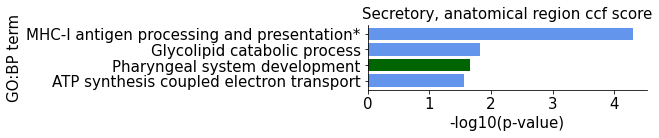

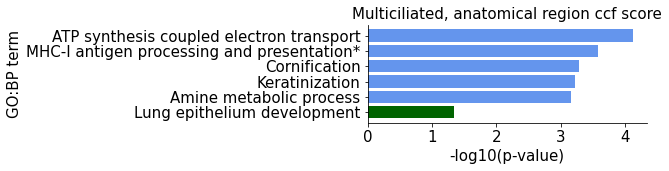

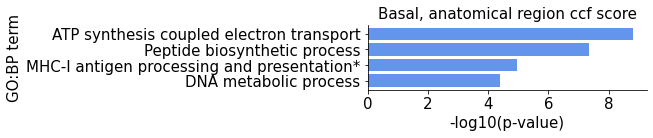

In [19]:
cov = "anatomical_region_ccf_score"
for ct, ct_terms in selected_terms_ccf.items():
    res = gobp_results[f"{ct}_{cov}"].loc[ct_terms, :]
    FIGURES[f"4b_{cov}_{ct}_genesets"] = plot_GSEA_results(ct, cov, res)

#### Number of basal cells along anatomical region ccf score axis (proximal to distal) (extended data figure 8a):

Get anatomical region information for every sample, and get cell type counts for every sample:

In [20]:
# get basal cell count per sample
sample_info = (
    adata.obs.groupby(["ann_level_3", "sample"])
    .agg(
        {
            "ann_level_3": "count",
        }
    )
    .loc["Basal", :]
).rename(columns={"ann_level_3": "basal_count"})
# get anatomical region ccf score
sample_info["anatomical_region_ccf_score"] = (
    adata.obs.groupby("sample")
    .agg({"anatomical_region_ccf_score": "first"})
    .loc[sample_info.index]
)
sample_info["n_cells_total"] = adata.obs["sample"].value_counts().loc[sample_info.index]
sample_info["perc_basal"] = sample_info.basal_count / sample_info.n_cells_total * 100

In [21]:
sample_info

,basal_count,anatomical_region_ccf_score,n_cells_total,perc_basal
sample,,,,
356C_0h,1,0.97,3770,0.026525
356C_12h,0,0.97,3464,0.000000
356C_24h,1,0.97,3683,0.027152
356C_72h,0,0.97,2611,0.000000
368C_0h,0,0.97,505,0.000000
...,...,...,...,...
distal 1a,77,0.97,7521,1.023800
distal 2,109,0.97,18540,0.587918
distal 3,77,0.97,16897,0.455702


filter out noses (since modeled separately), i.e. ccf == 0

In [22]:
sample_info = sample_info.loc[~(sample_info.anatomical_region_ccf_score == 0), :].copy()

Plot scatter:

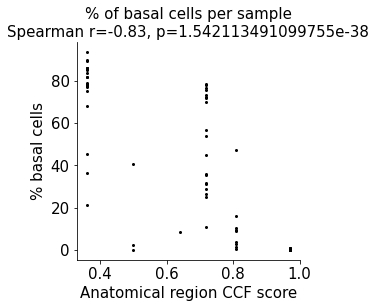

In [23]:
fz = 15
with plt.rc_context(
    {
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    }
):

    fig, ax = plt.subplots(figsize=(4, 4))
    x = sample_info.anatomical_region_ccf_score
    y = sample_info.perc_basal
    corr, p = spearmanr(x, y)
    ax.scatter(
        x,
        y,
        s=4,
        color="black",
    )
    plt.xlabel("Anatomical region CCF score", fontsize=fz)
    plt.ylabel("% basal cells", fontsize=fz)
    plt.title(
        f"% of basal cells per sample\nSpearman r={round(corr,2)}, p={p}",
        fontsize=fz,
    )
    plt.show()
    FIGURES["ED8a_perc_of_basal_cells_vs_anatomical_location_ccf"] = fig
    plt.close()

Show also as boxplot (shows distribution better), exclude categories (i.e. locations) with fewer than min_n_samples. This figure is currently not included in the paper but I think it is better than the above. The only thing is that the x-axis is not continuous but categorical.

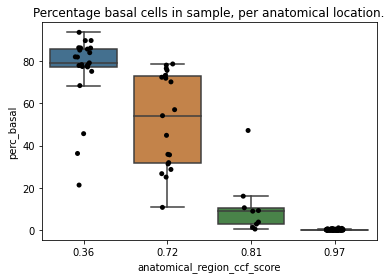

In [24]:
fig, ax = plt.subplots()
x = sample_info.anatomical_region_ccf_score
# exclude categories with fewer than min_n_samples samples:
min_n_samples = 5
cat_counts = x.value_counts()
cats_to_drop = cat_counts.index[cat_counts < min_n_samples]
xy_filter = ~x.isin(cats_to_drop)
x_filtered = x[xy_filter]
y = sample_info.perc_basal
y_filtered = y[xy_filter]
sns.stripplot(x=x_filtered, y=y_filtered, color="black")
sns.boxplot(
    x=x_filtered, y=y_filtered, saturation=0.5, fliersize=0
)  # exclude outliers as they are already shown in the stripplot
plt.title("Percentage basal cells in sample, per anatomical location.")
plt.show()
plt.close()

### Store figures:

In [25]:
FIGURES

{'ED8b_BMI_genesets_up_down_per_ct': <Figure size 360x216 with 1 Axes>,
 '4c_BMI_Secretory_genesets': <Figure size 360x86.4 with 1 Axes>,
 '4c_BMI_AT2_genesets': <Figure size 360x108 with 1 Axes>,
 '4c_BMI_Alveolar macrophages_genesets': <Figure size 360x86.4 with 1 Axes>,
 '4c_BMI_Plasma cells_genesets': <Figure size 360x86.4 with 1 Axes>,
 '4b_anatomical_region_ccf_score_Secretory_genesets': <Figure size 360x86.4 with 1 Axes>,
 '4b_anatomical_region_ccf_score_Multiciliated_genesets': <Figure size 360x129.6 with 1 Axes>,
 '4b_anatomical_region_ccf_score_Basal_genesets': <Figure size 360x86.4 with 1 Axes>,
 'ED8a_perc_of_basal_cells_vs_anatomical_location_ccf': <Figure size 288x288 with 1 Axes>}

In [27]:
# for figname, fig in FIGURES.items():
#     print("Storing", figname)
#     fig.savefig(
#         os.path.join(dir_figures, f"{figname}.png"),
#         bbox_inches="tight",
#         dpi=140,
#         transparent=True,
#     )
#     plt.close()